In [5]:
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [280]:
# !pip install open-tamil
import tamil
import codecs
from tamil import utf8

with open('./tamil_names.txt') as f:
    names_data = list(map(tamil.utf8.get_letters, list(map(str.strip, f.readlines()))))
names_data[0]

['அ', 'க', 'த்', 'தி', 'ய', 'ன்']

In [237]:
# create i_to_s and s_to_i mapping dict 
chars = ['.'] + sorted(set([j for i in names_data for j in i]))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}
len(itos)

209

Not required

In [267]:
X, Y = [], []
block_size = 3
for w in names_data:
    context = [0] * block_size
    for ch in w + ['.']:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join([itos[i] for i in context]), '-->' , ch)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
print(f"{X.shape=} {Y.shape=}")

X.shape=torch.Size([16869, 3]) Y.shape=torch.Size([16869])


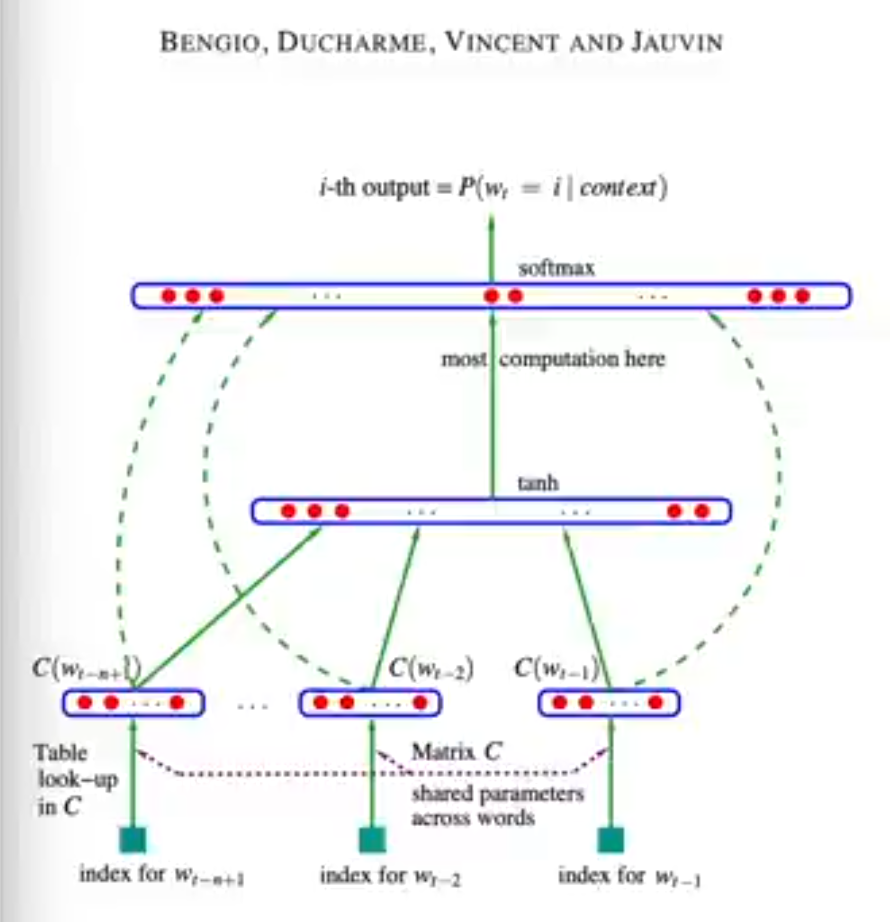

In [259]:
num_classes, block_size, n_emb = len(stoi), 3, 2
num_classes, block_size, n_emb

(209, 3, 2)

In [462]:
g = torch.Generator().manual_seed(1337)
C = torch.randn((num_classes, n_emb) , generator=g)
W1 = torch.randn((n_emb * block_size, 100), generator = g)
b1 = torch.randn(100, generator = g)

W2 = torch.randn((W1.shape[1], num_classes), generator = g)
b2 = torch.randn(num_classes, generator = g)

parameters = [C, W1, b1, W2, b2]

In [463]:
# n parameters
sum([p.nelement() for p in parameters])

26299

In [464]:
hy, hx = torch.histogram(W2.grad, density=True)
plt.plot(hx[:-1].detach(), hy.detach())


TypeError: histogram() received an invalid combination of arguments - got (NoneType, density=bool), but expected one of:
 * (Tensor input, Tensor bins, *, Tensor weight, bool density, tuple of Tensors out)
 * (Tensor input, int bins, *, tuple of floats range, Tensor weight, bool density, tuple of Tensors out)


In [465]:
# set grads
for n in parameters:
    n.requires_grad = True

In [469]:
for _ in range(10000):
    # minibatch
    ix = torch.randint(0, X.shape[0], (32,) ) # (0, X.shape[0]) -> 32 of them
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, block_size * n_emb) @ W1 + b1)
    logits = (h @ W2 +b2)

    loss = F.cross_entropy(logits, Y[ix])    
    # zero grad
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())


2.948345184326172


In [470]:
with torch.no_grad():
    emb = C[X]
    h = torch.tanh(emb.view(-1, block_size * n_emb) @ W1 + b1)
    logits = (h @ W2 +b2)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

2.8665289878845215


In [471]:
g = torch.Generator().manual_seed(1337)
for i in range(10):
    outs = []
    context = [0] * block_size
    while True:
        emb = C[ torch.tensor( [context] ) ]
        h = torch.tanh( emb.view(-1, block_size * n_emb) @ W1 + b1 )
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        outs.append(itos[ix])
    print(''.join(outs))

ஷரிப்பல்லி
தினலிங்கம்
சுககிவர்
திபிஷ்ந
சளன்
கவபாரன்
கிஷிலி
ககாவி
நிரராஜ்
சிவிஷ்


In [6]:
len(names_data)

2910

In [3]:
import random

# !pip install open-tamil
import tamil
import codecs
from tamil import utf8

with open('./tamil_names.txt') as f:
    names_data = list(map(tamil.utf8.get_letters, list(map(str.strip, f.readlines()))))
names_data[0]

# create i_to_s and s_to_i mapping dict 
chars = ['.'] + sorted(set([j for i in names_data for j in i]))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}
len(itos)

209

In [6]:
def build_dataset(dataset, mode='train', block_size=3):
    X, Y, l = [], [], len(dataset)
    start_index, end_index = 0, int(l*0.8)
    if mode == 'val': start_index, end_index = int(l*0.8), int(l*0.85)
    if mode == 'test': start_index, end_index = int(l*0.85), l
    for w in dataset[start_index:end_index]:
        context = [0] * block_size
        for ch in w + ['.']:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(f"{mode=}, {X.shape=}, {Y.shape=}")
    return X, Y

random.shuffle(names_data)
block_size = 3
Xtrain, Ytrain = build_dataset(names_data, mode='train')
Xval, Yval = build_dataset(names_data, mode='val')
Xtest, Ytest = build_dataset(names_data, mode='test')

mode='train', X.shape=torch.Size([13450, 3]), Y.shape=torch.Size([13450])
mode='val', X.shape=torch.Size([847, 3]), Y.shape=torch.Size([847])
mode='test', X.shape=torch.Size([2572, 3]), Y.shape=torch.Size([2572])


In [32]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.w = torch.randn((fan_in, fan_out))/ fan_in**0.5
        self.b = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.w] + ([self.b] if self.b is not None else [])
    
# here we want to normlize give tensor `x`, while also maintaining running mean and var
# for the purpose of 
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma, self.beta = torch.ones(dim), torch.zeros(dim)
        self.running_mean, self.running_var = torch.zeros(dim), torch.ones(dim)
        
    def __call__(self, x):
        if self.training: 
            xmean = x.mean(0, keepdim=True) # calculate batch mean
            xvar = x.var(0, keepdim=True) # calculateh variance
            
            ## update the running mean
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean)/ torch.sqrt(xvar + self.eps)
        #self.out = sum(xhat * self.gamma, self.beta)
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [33]:
n_emb, vocab_size, n_hidden = 10, len(stoi), 100
g = torch.Generator().manual_seed(1337)
    
C = torch.randn((vocab_size, n_emb) , generator=g)
layers = [
    Linear(n_emb * block_size , n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.w *= 1.0 #5/3

parameters = [C] + [p for l in layers for p in l.parameters()]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))    

67408


#### flow:
```
for max_steps:
    - randomly pluck out 'mini-batch' sized records from train set
        - randint( low=0, high=max_len(train_record), dimension=(batch_size,) )
    - get embedding for all of the selected mini-batch train records.
    - stack column-wise all the embeddings
    - start with x, pass through the results to subsequent layers -> x = layer(x)
    - calculate loss
    - set all layers grad to None 
    - backprob
    - update the weights by lr * grad
```

torch.randn vs torch.rand -> shooting myself in foot

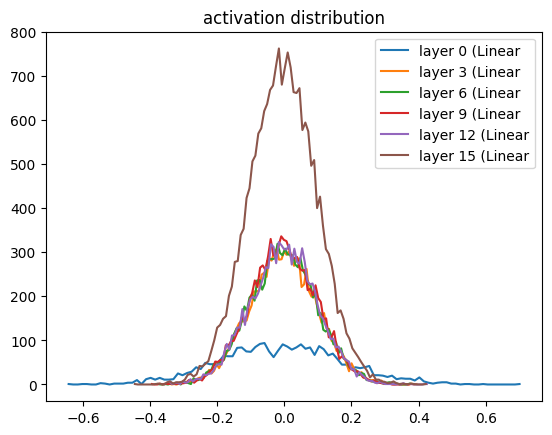

In [34]:
legends = []
for i, l in enumerate(layers):
    if isinstance(l, Linear):
        hy, hx = torch.histogram(l.w)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({l.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

In [35]:
batch_size, max_steps = 32, 100000
ud = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
    xb, yb = Xtrain[ix], Ytrain[ix]
    
    # 
    emb = C[xb]
    x = emb.view(emb.shape[0], n_emb* block_size)
    for l in layers:
        #print(f"before: {x.shape=}")
        x = l(x)
        #print(f"after: '{type(l).__name__}' {x.shape=}")
    loss = F.cross_entropy(x, yb)
    
    # 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    if i %1000 == 0:
        print(f"{i}/{max_steps} {loss.data=}")
    
    lr = 0.01
    for p in parameters:
        p.data += lr * -p.grad
        
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
        
print(f"{loss=}")

0/100000 loss.data=tensor(5.3521)
1000/100000 loss.data=tensor(4.6129)
2000/100000 loss.data=tensor(4.8283)
3000/100000 loss.data=tensor(4.1353)
4000/100000 loss.data=tensor(4.4057)
5000/100000 loss.data=tensor(4.2072)
6000/100000 loss.data=tensor(3.4905)
7000/100000 loss.data=tensor(3.6845)
8000/100000 loss.data=tensor(3.3343)
9000/100000 loss.data=tensor(3.6522)
10000/100000 loss.data=tensor(3.5115)
11000/100000 loss.data=tensor(3.6080)
12000/100000 loss.data=tensor(3.0979)
13000/100000 loss.data=tensor(2.7313)
14000/100000 loss.data=tensor(3.2230)
15000/100000 loss.data=tensor(4.2983)


KeyboardInterrupt: 

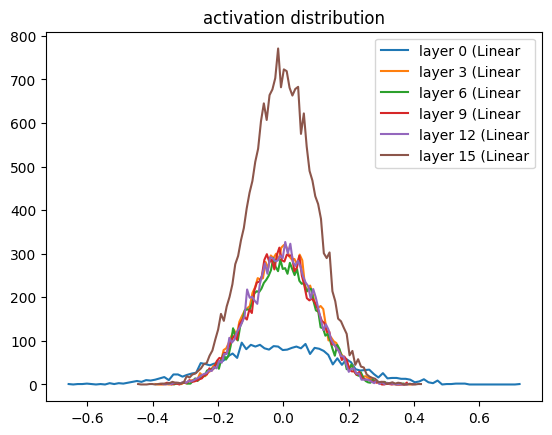

In [36]:
legends = []
for i, l in enumerate(layers):
    if isinstance(l, Linear):
        hy, hx = torch.histogram(l.w.data)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({l.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

t.shape=torch.Size([1, 100])
layer 2 (      Tanh): mean +0.03, std 0.66, saturated: 11.00%
t.shape=torch.Size([1, 100])
layer 5 (      Tanh): mean +0.10, std 0.68, saturated: 10.00%
t.shape=torch.Size([1, 100])
layer 8 (      Tanh): mean +0.11, std 0.71, saturated: 8.00%
t.shape=torch.Size([1, 100])
layer 11 (      Tanh): mean +0.00, std 0.73, saturated: 12.00%
t.shape=torch.Size([1, 100])
layer 14 (      Tanh): mean -0.01, std 0.65, saturated: 4.00%


Text(0.5, 1.0, 'activation distribution')

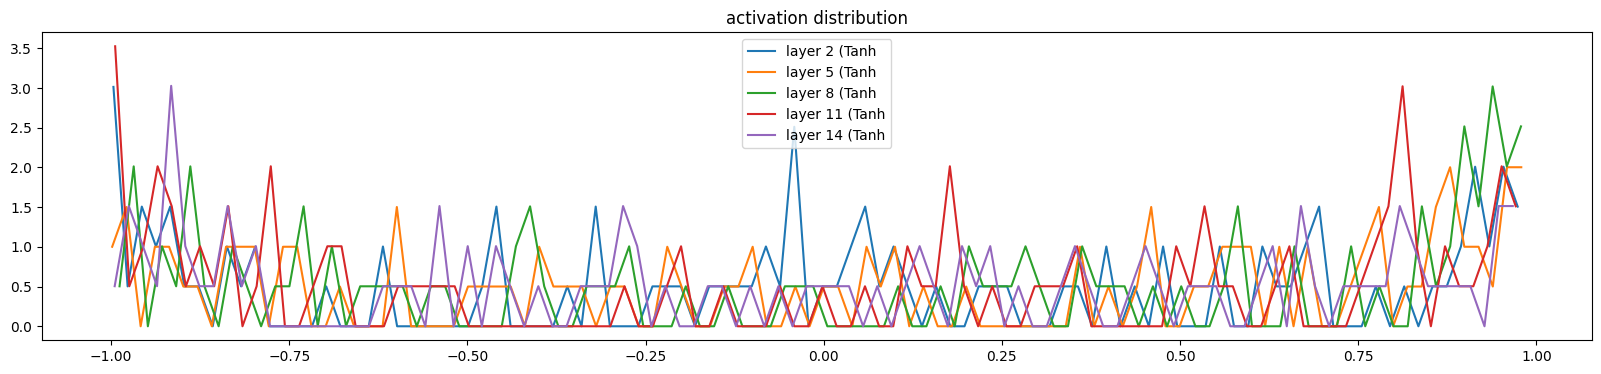

In [47]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print(f"{t.shape=}")
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

grads  (209, 10) | mean +0.000000 | std 8.395794e-03 | grad:data ratio 8.342262e-03
grads  (30, 100) | mean -0.000474 | std 1.756548e-02 | grad:data ratio 6.324501e-02
grads (100, 100) | mean -0.000015 | std 1.276653e-02 | grad:data ratio 7.523724e-02
grads (100, 100) | mean +0.000089 | std 1.383774e-02 | grad:data ratio 8.001080e-02
grads (100, 100) | mean +0.000154 | std 1.413776e-02 | grad:data ratio 8.152051e-02
grads (100, 100) | mean +0.000062 | std 1.333214e-02 | grad:data ratio 8.008321e-02
grads (100, 209) | mean -0.000048 | std 9.317433e-03 | grad:data ratio 6.796997e-02


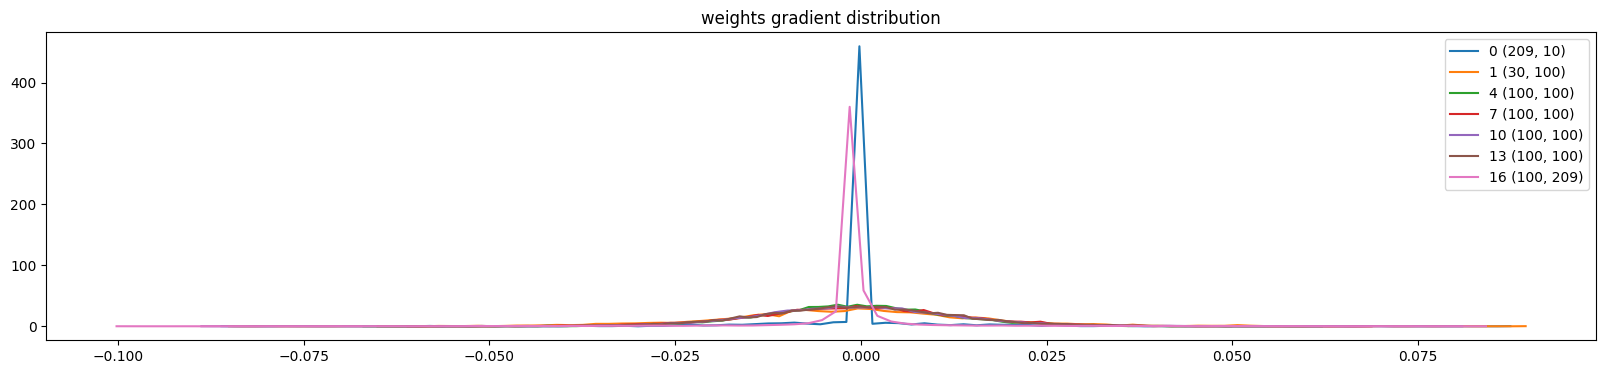

In [48]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('grads %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

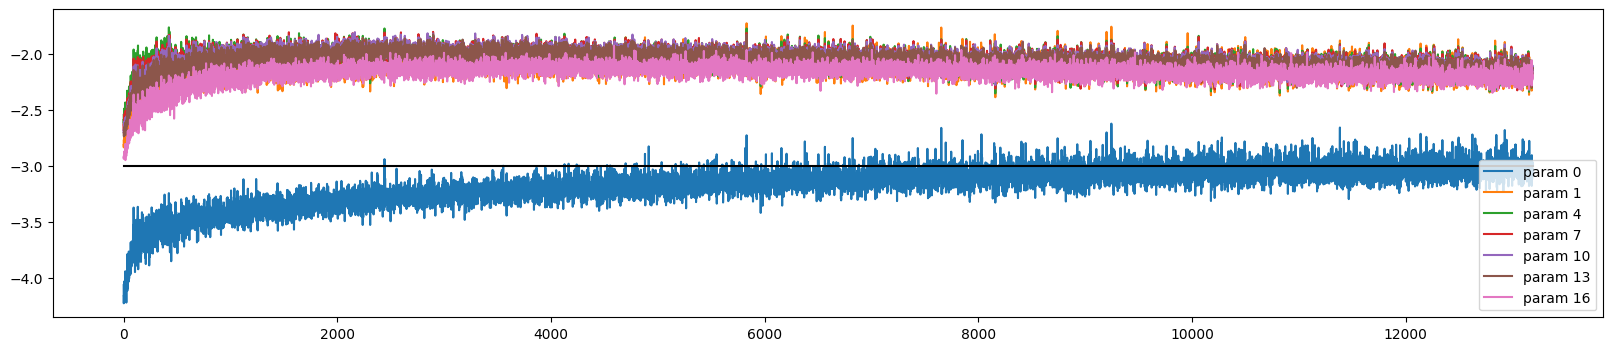

In [49]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [45]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtrain, Ytrain),
    'val': (Xval, Yval),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')


train 2.1610703468322754
val 3.1540558338165283


In [46]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word


விஷ்ப்பரவின்.
யோகதேரை.
பானுமைசர்த்து.
வ்யான்.
பேரறிலி.
அர்நாயன்.
பிரியா.
லகைசந்திரஞதத்ன்செல்வி.
இசையரசன்.
அயூயெமகள்.
முத்து.
யோத்ரு.
சோலைக்கோ.
யோகயஜுன்.
விஸ்வானி.
லக்ந்யஜ்.
சேரஹே.
காருந்தன்.
இலச்செல்வி.
சோகோச்செல்வன்.


In [42]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(1337) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


67408


Text(0.5, 1.0, 'activation distribution')

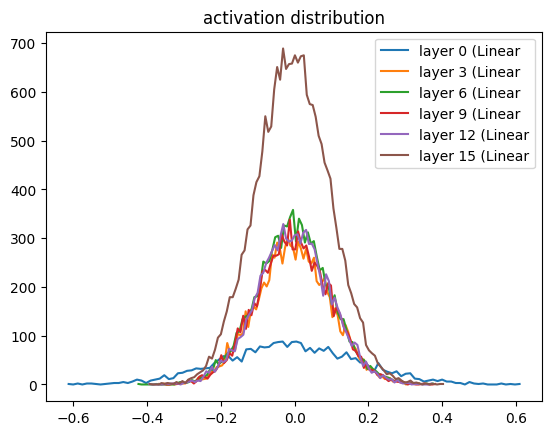

In [43]:
for l in layers:
    if isinstance(l, Linear):
        hy, hx = torch.histogram(l.weight)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({l.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [453]:
torch.randn((10,3))

tensor([[ 0.0996, -1.1761,  1.4986],
        [-1.4131, -0.3188,  1.0946],
        [-0.0709,  1.7560,  0.6981],
        [ 0.6707, -0.2956,  0.0471],
        [-0.4572,  1.4504,  0.3478],
        [ 0.7511,  0.8628,  0.1569],
        [-1.0409, -0.3605, -0.0325],
        [ 0.2979, -0.3385,  0.4706],
        [-0.5950,  0.8034,  1.0632],
        [ 0.0982,  0.4284, -0.3524]])

In [44]:
max_steps = 50000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtrain[ix], Ytrain[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
#
#  if i >= 1000:
#    break # AFTER_DEBUG: would take out obviously to run full optimization


      0/  50000: 5.3724
   1000/  50000: 3.5094
   2000/  50000: 3.9883
   3000/  50000: 3.2158
   4000/  50000: 3.4114
   5000/  50000: 2.9042
   6000/  50000: 3.2019
   7000/  50000: 2.4455
   8000/  50000: 3.3842
   9000/  50000: 2.3279
  10000/  50000: 2.1722
  11000/  50000: 2.9886
  12000/  50000: 1.6033
  13000/  50000: 2.8601


KeyboardInterrupt: 

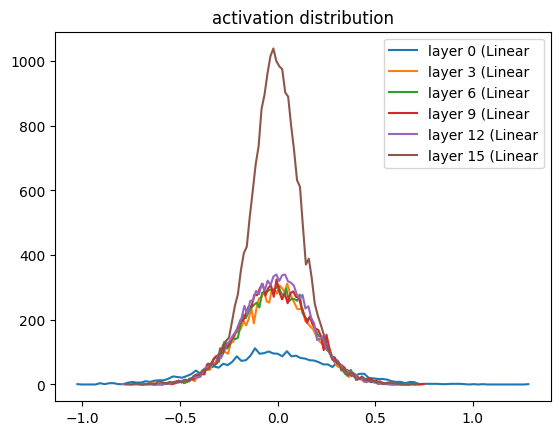

In [28]:
legends = []
for i, l in enumerate(layers):
    if isinstance(l, Linear):
        hy, hx = torch.histogram(l.weight.data)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({l.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()